In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('paper')
sns.set_style('white')

In [3]:
import pandas as pd
import configs

In [4]:
import os

In [5]:
import pickle
with open('hp_search/conf_json3/cnn_confs.pkl', 'rb') as f:
    cnn_confs = pickle.load(f)
with open('hp_search/conf_json3/lstm_confs.pkl', 'rb') as f:
    lstm_confs = pickle.load(f)
with open('hp_search/conf_json3/nochar_confs.pkl', 'rb') as f:
    nochar_confs = pickle.load(f)

In [6]:
len(cnn_confs[0]), len(lstm_confs[0]), len(nochar_confs[0])

(24, 23, 21)

In [10]:
models_folder = 'hp_search/models7'
conf_folder = 'hp_search/conf7'
json_folder = 'hp_search/conf_json7'
logs_folder = 'hp_search/logs7'


In [11]:
if not os.path.exists(models_folder):
    os.mkdir(models_folder)
if not os.path.exists(conf_folder):
    os.mkdir(conf_folder)
if not os.path.exists(json_folder):
    os.mkdir(json_folder)
if not os.path.exists(logs_folder):
    os.mkdir(logs_folder)

In [12]:
import json
def create_all_confs(confs, arch_name, ds_name, emb_name, conf_folder, models_folder, json_folder):
    max_digits = len(str(len(confs)))
    full_confs = []
    for i, conf in enumerate(confs):
        fc = configs.create_conf_file(os.path.join(conf_folder, arch_name+f'.{str(i).zfill(max_digits)}.conf'), 
                                 os.path.join(models_folder, arch_name+f'.{str(i).zfill(max_digits)}.model'), 
                                 ds_name, 
                                 conf, 
                                 emb_name)
        full_confs.append(fc)

    for i, fc in enumerate(full_confs):
        with open( os.path.join(json_folder, arch_name+f'.{str(i).zfill(max_digits)}.json'), 'w') as of:
            of.write(json.dumps(fc))

In [13]:
create_all_confs(lstm_confs, 'morph_charlstm', 'gold_morpheme', 'alt_tok_yap_w2v_sg7', 
                 conf_folder, models_folder, json_folder)

In [14]:
create_all_confs(cnn_confs, 'morph_charcnn', 'gold_morpheme', 'alt_tok_yap_w2v_sg7', 
                 conf_folder, models_folder, json_folder)

## Token

In [15]:
create_all_confs(lstm_confs, 'token_charlstm', 'gold_token_bioes', 'alt_tok_tokenized_w2v_sg7', 
                 conf_folder, models_folder, json_folder)

In [16]:
create_all_confs(cnn_confs, 'token_charcnn', 'gold_token_bioes', 'alt_tok_tokenized_w2v_sg7', 
                 conf_folder, models_folder, json_folder)

## Token Multi-Tag

In [17]:
create_all_confs(lstm_confs, 'multitok_charlstm', 'gold_token_raw', 'alt_tok_tokenized_w2v_sg7', 
                 conf_folder, models_folder, json_folder)

In [18]:
create_all_confs(cnn_confs, 'multitok_charcnn', 'gold_token_raw', 'alt_tok_tokenized_w2v_sg7', 
                 conf_folder, models_folder, json_folder)

## NoChar

In [19]:
create_all_confs(nochar_confs, 'morph_nochar', 'gold_morpheme', 'alt_tok_yap_w2v_sg7', 
                 conf_folder, models_folder, json_folder)

In [20]:
create_all_confs(nochar_confs, 'token_nochar', 'gold_token_bioes', 'alt_tok_tokenized_w2v_sg7', 
                 conf_folder, models_folder, json_folder)

In [21]:
create_all_confs(nochar_confs, 'multitok_nochar', 'gold_token_raw', 'alt_tok_tokenized_w2v_sg7', 
                 conf_folder, models_folder, json_folder)

# RUNNING ON NLP08, NLP10, NLP11, NLP13, NLP05, NLP14
cd NCRFpp/  
conda activate ncrf_gpu  
python run4_hp_search.py 3 token_charlstm.2  


## Check results

In [7]:
import pickle
with open('hp_search/conf_json3/cnn_confs.pkl', 'rb') as f:
    cnn_confs = pickle.load(f)
with open('hp_search/conf_json3/lstm_confs.pkl', 'rb') as f:
    lstm_confs = pickle.load(f)
with open('hp_search/conf_json3/nochar_confs.pkl', 'rb') as f:
    nochar_confs = pickle.load(f)

In [19]:
len(cnn_confs[0]), len(lstm_confs[0]), len(nochar_confs[0])

(24, 23, 21)

In [58]:
import re
import os
DEV_RES_LINE = re.compile('Dev: .*; acc: (?P<acc>[^,]+)(?:, p: (?P<p>[^,]+), r: (?P<r>[^,]+), f: (?P<f>[-\d\.]+))?')
#Dev: time: 0.94s speed: 536.09st/s; acc: 0.9043
#Dev: time: 3.42s, speed: 146.59st/s; acc: 0.9546, p: 0.7577, r: 0.6393, f: 0.6935

mtimes = []
res = []
archs = []
for f in os.scandir('hp_search/logs7'):
    if f.name.startswith('.ipy'):
        continue
    mtimes.append(os.path.getmtime(f.path))
    arch = f.name.split('.')[0]
    archs.append(arch)
    unit = arch.split('_')[0]
    conf_num = f.name.split('.')[1]
    if 'cnn' in arch:
        matching_conf = cnn_confs[int(conf_num)] 
    elif 'lstm' in arch: 
        matching_conf = lstm_confs[int(conf_num)]
    elif 'nochar' in arch:
        matching_conf = nochar_confs[int(conf_num)]
    params = { 'arch': arch, 'unit': unit, 'conf_num': conf_num}
    params.update(matching_conf)
    with open(f.path, 'r') as fp:
        i= 0
        for line in fp:
            m = DEV_RES_LINE.match(line)
            if m:
                r = m.groupdict().copy()
                for k, v in r.items():
                    if v is not None:
                        r[k] = float(v)
                r.update(params)
                r['epoch'] = i
                i+=1
                res.append(r)

rdf = pd.DataFrame(res)

rdf['model_file_name'] = rdf.arch + '.' + rdf.conf_num +'.model.' + rdf.epoch.astype(str) + '.model'
rdf['dset_file_name'] =  rdf.arch + '.' + rdf.conf_num +'.model.dset'
rdf['char_seq_feature'] = rdf.char_seq_feature.fillna('NoChar')

rdf['relevant_score'] = rdf.f.fillna(rdf.acc)

erdf = rdf[(rdf.groupby(['conf_num', 'arch']).relevant_score.transform(max)==rdf.relevant_score) ]
erdf = erdf[(erdf.groupby(['conf_num', 'arch']).epoch.transform(min)==erdf.epoch) ]

In [59]:
erdf.shape

(27, 35)

In [60]:
erdf.groupby('arch').size()

arch
morph_charcnn        4
morph_charlstm       4
morph_nochar         4
multitok_charcnn     2
multitok_charlstm    2
multitok_nochar      2
token_charcnn        2
token_charlstm       5
token_nochar         2
dtype: int64

In [61]:
print ('Mean time per run:', round((max(mtimes) - min(mtimes) )/ len(mtimes) / 60, 2), 'minutes')

Mean time per run: 36.36 minutes


In [62]:
import numpy as np 
def perc(n):
    def perc_(x):
        return np.percentile(x, n)
    perc_.__name__ = 'perc_%s' % n
    return perc_

erdf.groupby(['unit', 'char_seq_feature']).f.agg(['max', 'min', 'mean', 'std', 'median', perc(95)])

max     min     mean       std   median  \
unit     char_seq_feature                                               
morph    CNN               0.6996  0.6787  0.68980  0.008626  0.69045   
         LSTM              0.7083  0.7043  0.70605  0.002014  0.70580   
         NoChar            0.6835  0.6518  0.66550  0.014912  0.66335   
multitok CNN                  NaN     NaN      NaN       NaN      NaN   
         LSTM                 NaN     NaN      NaN       NaN      NaN   
         NoChar               NaN     NaN      NaN       NaN      NaN   
token    CNN               0.6378  0.6302  0.63400  0.005374  0.63400   
         LSTM              0.6404  0.6229  0.63220  0.006278  0.63180   
         NoChar            0.6097  0.5951  0.60240  0.010324  0.60240   

                            perc_95  
unit     char_seq_feature            
morph    CNN               0.698415  
         LSTM              0.708135  
         NoChar            0.681760  
multitok CNN                    NaN  
         LSTM                   NaN  
         NoChar                 NaN  
token    CNN               0.637420  
         LSTM              0.639140  
         NoChar            0.608970

## Evaluate files (Mention Evaluation)

In [63]:
import sys
sys.path.append('../NER')

In [64]:
import ne_evaluate_mentions as nem

## Create configs for decoding

In [67]:
model_folder = 'hp_search/models7'
output_folder = 'hp_search/decode_output7'
conf_folder = 'hp_search/decode_conf7'
logs_folder = 'hp_search/decode_logs7'

if not os.path.exists(output_folder):
    os.mkdir(output_folder)

if not os.path.exists(conf_folder):
    os.mkdir(conf_folder)
    
if not os.path.exists(logs_folder):
    os.mkdir(logs_folder)

    decode_sets = {
    'morph': {
        'morph_dev_gold': '../NER/data/for_ncrf/morph_gold_dev.bmes',
        'morph_dev_yap': '../NER/data/for_ncrf/morph_yap_dev_dummy_o.bmes',
        'morph_test_gold': '../NER/data/for_ncrf/morph_gold_test.bmes',
        'morph_test_yap': '../NER/data/for_ncrf/morph_yap_test_dummy_o.bmes',
    },
    'token': {
        'token_dev': '../NER/data/for_ncrf/token_gold_dev_fix.bmes',
        'token_test': '../NER/data/for_ncrf/token_gold_test_fix.bmes',
    },
    'multitok': {
        'token_dev': '../NER/data/for_ncrf/token_gold_dev_concat.bmes',
        'token_test': '../NER/data/for_ncrf/token_gold_test_concat.bmes',
    }
}

params = { 'status': 'decode' }

for i, row in erdf.iterrows():
    unit = row['arch'].split('_')[0]
    for name, set_path in decode_sets[unit].items():
        row_par = params.copy()
        row_par['load_model_dir'] = os.path.join(model_folder, row['model_file_name'])
        row_par['dset_dir'] = os.path.join(model_folder, row['dset_file_name'])
        row_par['decode_dir'] = os.path.join(output_folder, name+'.'+row['arch']+'.'+row['conf_num']+'.bmes')
        row_par['raw_dir'] = set_path
        
        conf_path = os.path.join(conf_folder, name+'.'+row['arch']+'.'+row['conf_num']+'.decode.conf')
        if not os.path.exists(conf_path):
            with open(conf_path, 'w', encoding='utf8') as of:
                for k, v in row_par.items():
                    of.write(k+'='+str(v)+'\n')        
 

## Evaluate decoded folder

In [59]:
scores = {}

In [60]:
if os.path.exists('hp_search/scores7.pkl'):
    scores = pickle.load(open('hp_search/scores7.pkl', 'rb'))

In [61]:
for file in os.scandir(output_folder):
    if file.name=='.ipynb_checkpoints':
        continue
    gold_name, arch, conf_num = file.name.split('.')[:3]
    if (gold_name, arch, conf_num) not in scores:
        _, charsf = arch.split('_')
        if len(gold_name.split('_'))>2:
            unit, pred_set, _ = gold_name.split('_')
            gold_path = decode_sets[unit][unit+'_'+pred_set+'_gold']
        else:
            unit, pred_set = gold_name.split('_')
            gold_path = decode_sets[unit][unit+'_'+pred_set]
        p, r, f = nem.evaluate_files(gold_path, file)
        scores[(gold_name, arch, conf_num)] = (p, r, f)
        
pickle.dump(scores, open('hp_search/scores7.pkl', 'wb'))

In [62]:
score_tups = [(*k, *v) for k,v in scores.items()]

In [63]:
mev = pd.DataFrame(score_tups, columns=('gold_name', 'arch', 'conf_num', 'p', 'r', 'f'))
mev[mev.gold_name.str.contains('dev')].groupby(['gold_name', 'arch']).f.agg(['max', 'min', 'mean', 'std', 'median', perc(95)])

max       min      mean       std  \
gold_name      arch                                                        
morph_dev_gold morph_charcnn      0.693182  0.629108  0.674156  0.026549   
               morph_charlstm     0.700114  0.694878  0.697496  0.003703   
               morph_nochar       0.686636  0.686636  0.686636       NaN   
morph_dev_yap  morph_charcnn      0.624714  0.590909  0.612677  0.013562   
               morph_charlstm     0.629418  0.626007  0.627713  0.002412   
               morph_nochar       0.616628  0.616628  0.616628       NaN   
token_dev      multitok_charcnn   0.644571  0.622322  0.631227  0.006732   
               multitok_charlstm  0.633406  0.622472  0.629038  0.005789   
               multitok_nochar    0.626374  0.620155  0.623264  0.004397   
               token_charcnn      0.654628  0.633028  0.643945  0.006425   
               token_charlstm     0.647123  0.632287  0.641763  0.008230   
               token_nochar       0.624130  0.620296  0.622213  0.002711   

                                    median   perc_95  
gold_name      arch                                   
morph_dev_gold morph_charcnn      0.684869  0.692888  
               morph_charlstm     0.697496  0.699852  
               morph_nochar       0.686636  0.686636  
morph_dev_yap  morph_charcnn      0.619154  0.623813  
               morph_charlstm     0.627713  0.629248  
               morph_nochar       0.616628  0.616628  
token_dev      multitok_charcnn   0.630435  0.640996  
               multitok_charlstm  0.631236  0.633189  
               multitok_nochar    0.623264  0.626063  
               token_charcnn      0.643914  0.652235  
               token_charlstm     0.645880  0.646998  
               token_nochar       0.622213  0.623938

In [64]:
mev['pred_set'] = mev.gold_name.apply(lambda x: '_'.join(x.split('_')[1:]).replace('_yap', ''))

In [65]:
mev = mev.set_index(['arch', 'conf_num', 'pred_set'])[['p', 'r', 'f']].unstack()
mev.columns = ['_'.join(col).rstrip('_') for col in mev.columns.values]
mev.head()

p_dev  p_dev_gold    p_test  p_test_gold     r_dev  \
arch          conf_num                                                          
morph_charcnn 00        0.558233    0.628514  0.534335     0.637339  0.695000   
              09        0.495984    0.538153  0.463519     0.530043  0.730769   
              10        0.536145    0.604418  0.530043     0.629828  0.735537   
              11        0.548193    0.612450  0.523605     0.634120  0.726064   
              20        0.538153    0.600402  0.532189     0.630901  0.699739   

                        r_dev_gold    r_test  r_test_gold     f_dev  \
arch          conf_num                                                
morph_charcnn 00          0.769042  0.654402     0.734240  0.619154   
              09          0.757062  0.645740     0.689944  0.590909   
              10          0.790026  0.675787     0.759379  0.620209   
              11          0.798429  0.658570     0.744332  0.624714   
              20          0.762755  0.672087     0.756757  0.608400   

                        f_dev_gold    f_test  f_test_gold  
arch          conf_num                                     
morph_charcnn 00          0.691713  0.588305     0.682366  
              09          0.629108  0.539663     0.599515  
              10          0.684869  0.594107     0.688563  
              11          0.693182  0.583383     0.684820  
              20          0.671910  0.594012     0.688122

In [66]:
erdf = erdf.merge(mev.reset_index(), on=['arch', 'conf_num'])

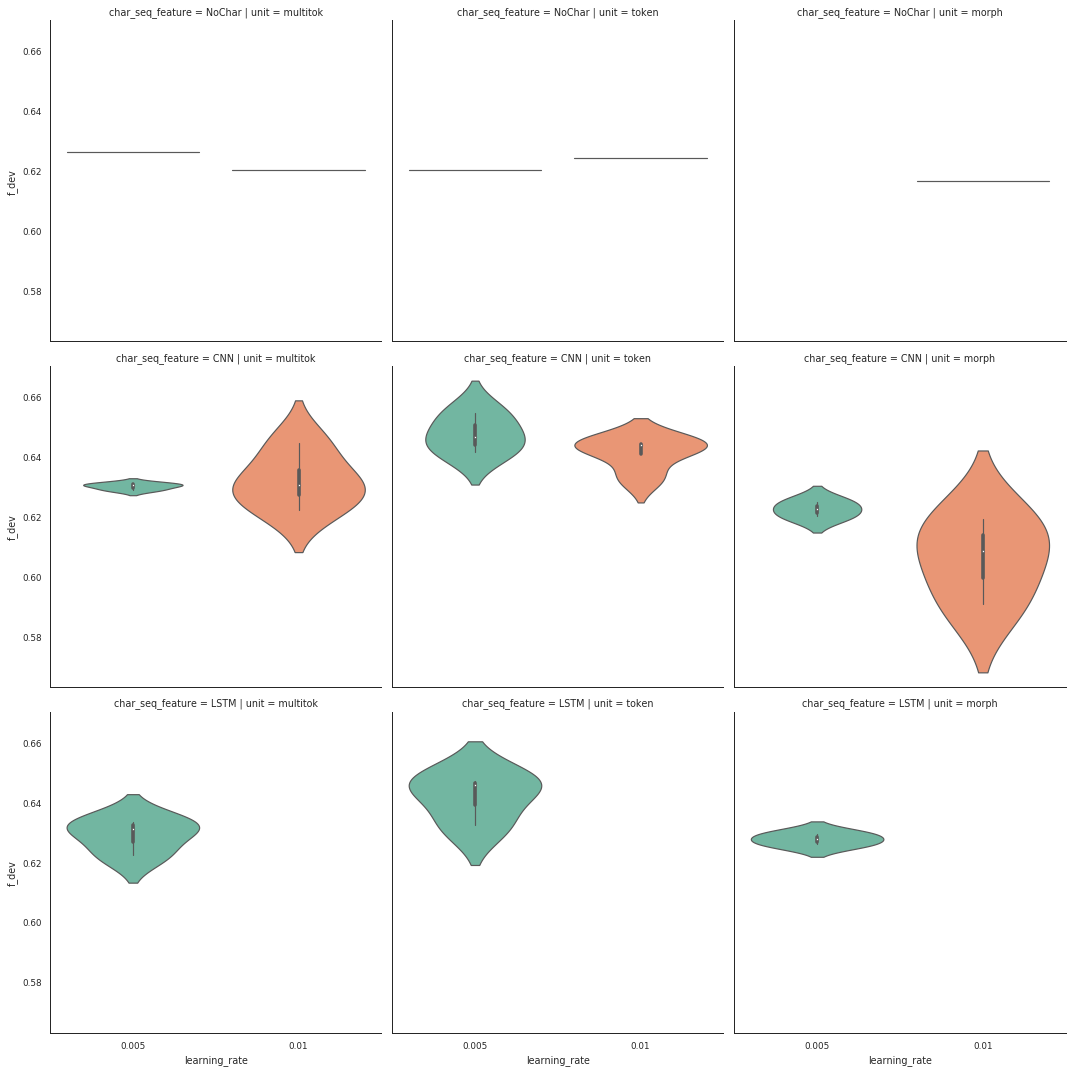

In [67]:
sns.catplot(kind='violin', row='char_seq_feature', col='unit', 
            x="learning_rate", y="f_dev", #hue='batch_size',
                data=erdf, palette="Set2",
                scale="count", inner="box", scale_hue=True)

In [ ]:
>>> g = sns.FacetGrid(erdf[erdf.unit=='morph'].rename(columns={'learning_rate': 'lr', 'char_seq_feature': 'charsf'}), col='charsf')
>>> g = g.map(plt.scatter, "f_dev_gold", "f_dev", edgecolor="w")

In [ ]:
cols = ['f', 'p', 'r', 'char_seq_feature', 'lstm_layer', 'batch_size', 
        'learning_rate', 'char_hidden_dim', 'char_kernel_size',
        'hidden_dim', 'dropout', 'epoch']

In [ ]:
(erdf[erdf.unit=='morph'].sort_values('f', ascending=False).head(20)[['arch', 'conf_num', 'epoch', 'f']]).fillna('')

In [ ]:
(erdf[erdf.unit=='token'].sort_values('f', ascending=False).head(20)[['arch', 'conf_num', 'epoch', 'f']]).fillna('')

In [254]:
(erdf[erdf.unit=='morph'].sort_values('f', ascending=False).head(20)[cols]).fillna('')

f       p       r char_seq_feature  lstm_layer  batch_size  \
21  0.8118  0.8591  0.7695              CNN           2           8   
19  0.8075  0.8398  0.7776           NoChar           2           8   
18  0.8000  0.8475  0.7575              CNN           2           8   
17  0.7996  0.8441  0.7595             LSTM           2           8   
22  0.7992  0.8407  0.7615             LSTM           2           8   
13  0.7987  0.8472  0.7555              CNN           2           8   
20  0.7979  0.8555  0.7475              CNN           2           8   
23  0.7975  0.8370  0.7615             LSTM           2           8   
34  0.7962  0.8516  0.7475              CNN           2           8   
32  0.7941  0.8344  0.7575             LSTM           2           8   
8   0.7920  0.8322  0.7555           NoChar           2           8   
35  0.7895  0.8315  0.7515              CNN           2           8   

    learning_rate char_hidden_dim char_kernel_size  hidden_dim  dropout  epoch  
21          0.010              50                5         200      0.4    103  
19          0.010                                          200      0.5    107  
18          0.010              70                7         200      0.4    116  
17          0.005              50                          200      0.5     74  
22          0.010              70                          200      0.4     92  
13          0.005              50                7         200      0.4     17  
20          0.010              50                5         200      0.5    124  
23          0.005              70                          200      0.4    104  
34          0.005              70                3         200      0.5     84  
32          0.005              50                          200      0.4    130  
8           0.005                                          200      0.4     29  
35          0.005              50                7         200      0.5     87

In [255]:
(erdf[erdf.unit=='morph'].sort_values('f', ascending=True).head(20)[cols]).fillna('')

f       p       r char_seq_feature  lstm_layer  batch_size  \
35  0.7895  0.8315  0.7515              CNN           2           8   
8   0.7920  0.8322  0.7555           NoChar           2           8   
32  0.7941  0.8344  0.7575             LSTM           2           8   
34  0.7962  0.8516  0.7475              CNN           2           8   
23  0.7975  0.8370  0.7615             LSTM           2           8   
20  0.7979  0.8555  0.7475              CNN           2           8   
13  0.7987  0.8472  0.7555              CNN           2           8   
22  0.7992  0.8407  0.7615             LSTM           2           8   
17  0.7996  0.8441  0.7595             LSTM           2           8   
18  0.8000  0.8475  0.7575              CNN           2           8   
19  0.8075  0.8398  0.7776           NoChar           2           8   
21  0.8118  0.8591  0.7695              CNN           2           8   

    learning_rate char_hidden_dim char_kernel_size  hidden_dim  dropout  epoch  
35          0.005              50                7         200      0.5     87  
8           0.005                                          200      0.4     29  
32          0.005              50                          200      0.4    130  
34          0.005              70                3         200      0.5     84  
23          0.005              70                          200      0.4    104  
20          0.010              50                5         200      0.5    124  
13          0.005              50                7         200      0.4     17  
22          0.010              70                          200      0.4     92  
17          0.005              50                          200      0.5     74  
18          0.010              70                7         200      0.4    116  
19          0.010                                          200      0.5    107  
21          0.010              50                5         200      0.4    103

In [256]:
(erdf[erdf.unit=='token'].sort_values('f', ascending=False).head(20)[cols]).fillna('')

f       p       r char_seq_feature  lstm_layer  batch_size  \
26  0.7928  0.8389  0.7515              CNN           2           8   
2   0.7835  0.8281  0.7435              CNN           2           8   
0   0.7829  0.8170  0.7515           NoChar           2           8   
25  0.7816  0.8166  0.7495              CNN           2           8   
27  0.7794  0.8190  0.7435              CNN           2           8   
9   0.7792  0.8113  0.7495             LSTM           2           8   
1   0.7760  0.8164  0.7395              CNN           2           8   
6   0.7749  0.8239  0.7315             LSTM           2           8   
28  0.7747  0.8039  0.7475             LSTM           2           8   
5   0.7671  0.8089  0.7295              CNN           2           8   
3   0.7669  0.8135  0.7255              CNN           2           8   
24  0.7637  0.8062  0.7255           NoChar           2           8   

    learning_rate char_hidden_dim char_kernel_size  hidden_dim  dropout  epoch  
26          0.010              70                7         200      0.5    104  
2           0.010              70                7         200      0.4     51  
0           0.010                                          200      0.5    111  
25          0.005              70                7         200      0.5     35  
27          0.010              70                3         200      0.4     74  
9           0.005              50                          200      0.5    126  
1           0.005              50                7         200      0.4     54  
6           0.010              70                          200      0.4     56  
28          0.005              70                          200      0.5     71  
5           0.010              50                5         200      0.4     56  
3           0.010              50                5         200      0.5    118  
24          0.005                                          200      0.5    101

In [257]:
(erdf[erdf.unit=='token'].sort_values('f', ascending=True).head(20)[cols]).fillna('')

f       p       r char_seq_feature  lstm_layer  batch_size  \
24  0.7637  0.8062  0.7255           NoChar           2           8   
3   0.7669  0.8135  0.7255              CNN           2           8   
5   0.7671  0.8089  0.7295              CNN           2           8   
28  0.7747  0.8039  0.7475             LSTM           2           8   
6   0.7749  0.8239  0.7315             LSTM           2           8   
1   0.7760  0.8164  0.7395              CNN           2           8   
9   0.7792  0.8113  0.7495             LSTM           2           8   
27  0.7794  0.8190  0.7435              CNN           2           8   
25  0.7816  0.8166  0.7495              CNN           2           8   
0   0.7829  0.8170  0.7515           NoChar           2           8   
2   0.7835  0.8281  0.7435              CNN           2           8   
26  0.7928  0.8389  0.7515              CNN           2           8   

    learning_rate char_hidden_dim char_kernel_size  hidden_dim  dropout  epoch  
24          0.005                                          200      0.5    101  
3           0.010              50                5         200      0.5    118  
5           0.010              50                5         200      0.4     56  
28          0.005              70                          200      0.5     71  
6           0.010              70                          200      0.4     56  
1           0.005              50                7         200      0.4     54  
9           0.005              50                          200      0.5    126  
27          0.010              70                3         200      0.4     74  
25          0.005              70                7         200      0.5     35  
0           0.010                                          200      0.5    111  
2           0.010              70                7         200      0.4     51  
26          0.010              70                7         200      0.5    104

In [258]:
erdf.groupby('arch').epoch.agg(['median', 'mean', 'std'])

median        mean        std
arch                                            
morph_charcnn          95   88.500000  38.370562
morph_charlstm         98  100.000000  23.494680
morph_nochar           68   68.000000  55.154329
multitok_charcnn      106  104.285714  48.082271
multitok_charlstm      83   83.000000  16.970563
multitok_nochar        87  111.333333  50.143128
token_charcnn          56   70.285714  30.313442
token_charlstm         71   84.333333  36.855574
token_nochar          106  106.000000   7.071068

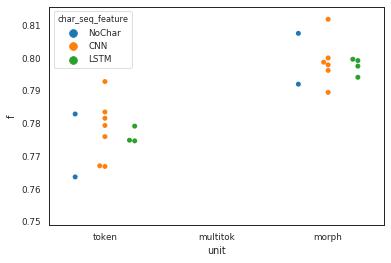

In [259]:
sns.swarmplot(data=erdf, x='unit', y='f', hue='char_seq_feature', dodge=True)


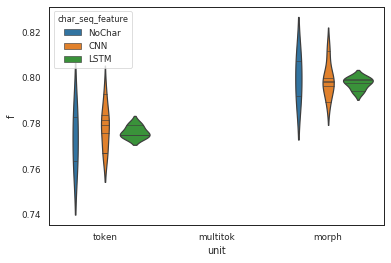

In [260]:
sns.violinplot(data=erdf, x='unit', y='f', hue='char_seq_feature', inner='stick')


## Learning rate

In [149]:
erdf.groupby(['optimizer', 'learning_rate', 'arch']).conf_num.nunique().unstack()

arch                     morph_charcnn  morph_charlstm  morph_nochar  \
optimizer learning_rate                                                
SGD       0.005                      7               4             2   
          0.010                     11               3             2   

arch                     multitok_charcnn  multitok_charlstm  multitok_nochar  \
optimizer learning_rate                                                         
SGD       0.005                         6                  4                2   
          0.010                        10                  4                2   

arch                     token_charcnn  token_charlstm  token_nochar  
optimizer learning_rate                                               
SGD       0.005                      8               4             2  
          0.010                      8               4             2

In [150]:
erdf.groupby(['optimizer', 'learning_rate', 'arch']).f.median().unstack()

arch                     morph_charcnn  morph_charlstm  morph_nochar  \
optimizer learning_rate                                                
SGD       0.005                 0.7832         0.79385         0.779   
          0.010                 0.7866         0.79090         0.780   

arch                     multitok_charcnn  multitok_charlstm  multitok_nochar  \
optimizer learning_rate                                                         
SGD       0.005                       NaN                NaN              NaN   
          0.010                       NaN                NaN              NaN   

arch                     token_charcnn  token_charlstm  token_nochar  
optimizer learning_rate                                               
SGD       0.005                0.76300         0.76480        0.7352  
          0.010                0.76615         0.77195        0.7431

In [151]:
erdf.groupby(['optimizer', 'learning_rate', 'arch']).f.max().unstack()

arch                     morph_charcnn  morph_charlstm  morph_nochar  \
optimizer learning_rate                                                
SGD       0.005                 0.7918          0.7974        0.7791   
          0.010                 0.7966          0.7918        0.7826   

arch                     multitok_charcnn  multitok_charlstm  multitok_nochar  \
optimizer learning_rate                                                         
SGD       0.005                       NaN                NaN              NaN   
          0.010                       NaN                NaN              NaN   

arch                     token_charcnn  token_charlstm  token_nochar  
optimizer learning_rate                                               
SGD       0.005                 0.7717          0.7676        0.7372  
          0.010                 0.7789          0.7749        0.7484

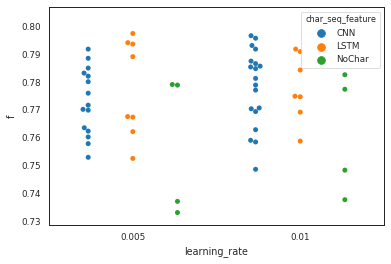

In [153]:
sns.swarmplot(data=erdf, x='learning_rate', y='f', hue='char_seq_feature', split=True)

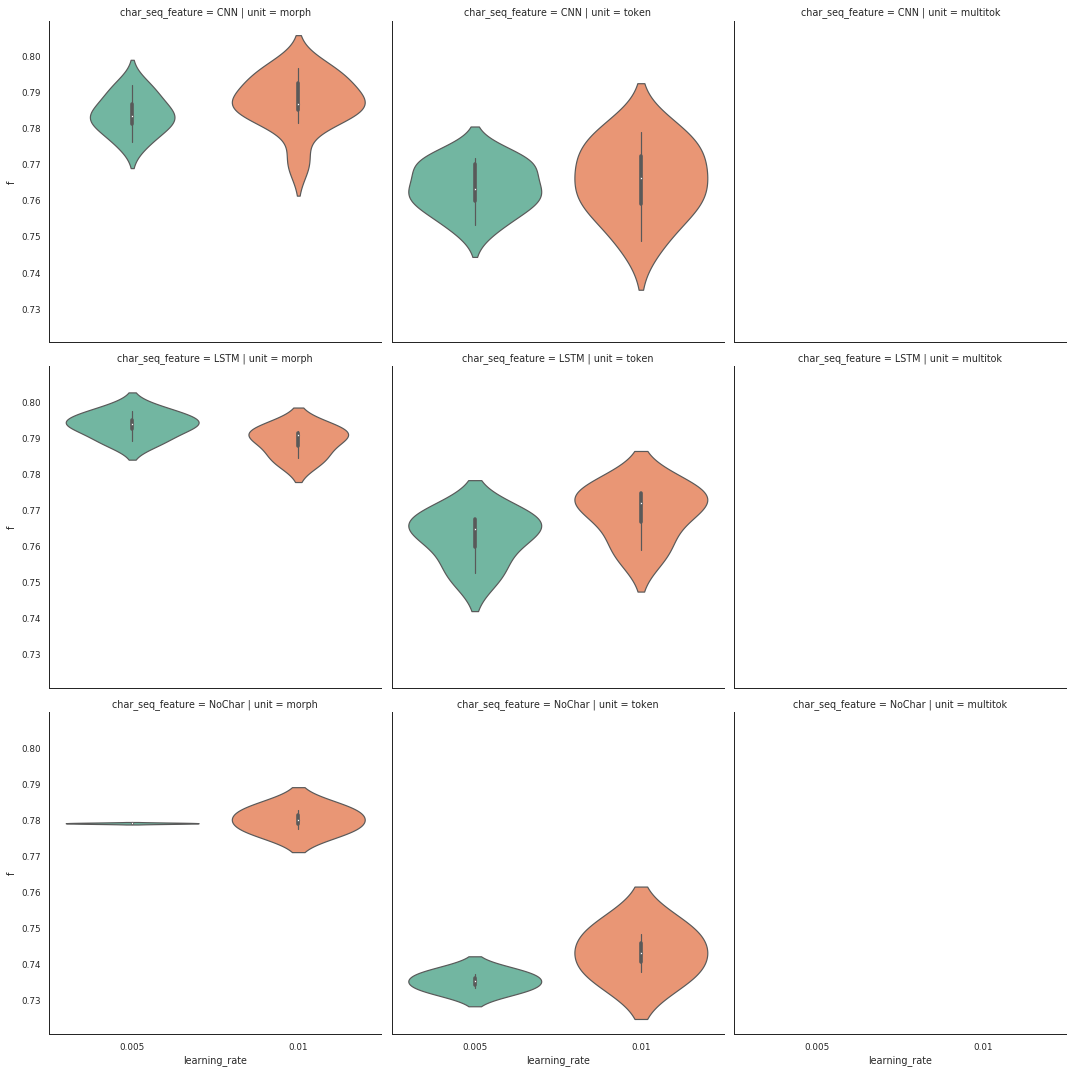

In [159]:
sns.catplot(kind='violin', row='char_seq_feature', col='unit', 
            x="learning_rate", y="f", #hue='batch_size',
                data=erdf, palette="Set2",
                scale="count", inner="box", scale_hue=True)

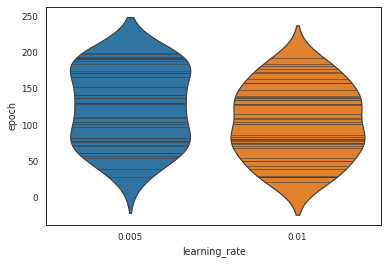

In [160]:
sns.violinplot(data=erdf, x='learning_rate', y='epoch', inner='stick')

### Do the lower scores in the lower learning rate come from lack of epochs?

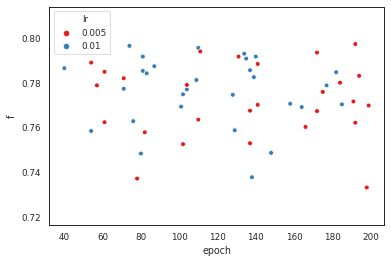

In [161]:
sns.scatterplot(data=erdf.assign(lr=lambda x: x.learning_rate.astype('str')), hue='lr', x='epoch', y='f',
               palette=sns.color_palette("Set1", erdf.learning_rate.nunique()))

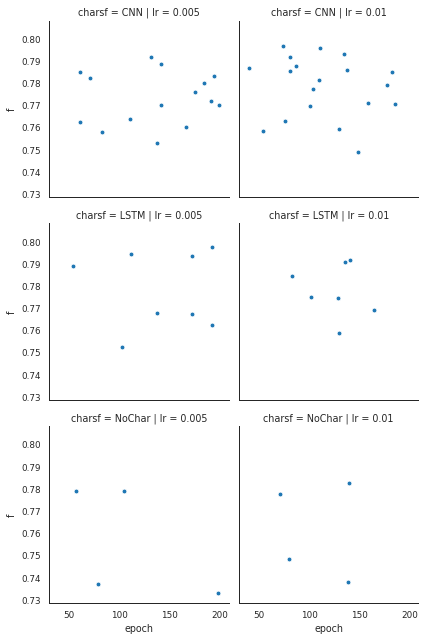

In [162]:
>>> g = sns.FacetGrid(erdf.rename(columns={'learning_rate': 'lr', 'char_seq_feature': 'charsf'}), col="lr", row='charsf')
>>> g = g.map(plt.scatter, "epoch", "f", edgecolor="w")

ValueError: The number of observations must be larger than the number of variables.

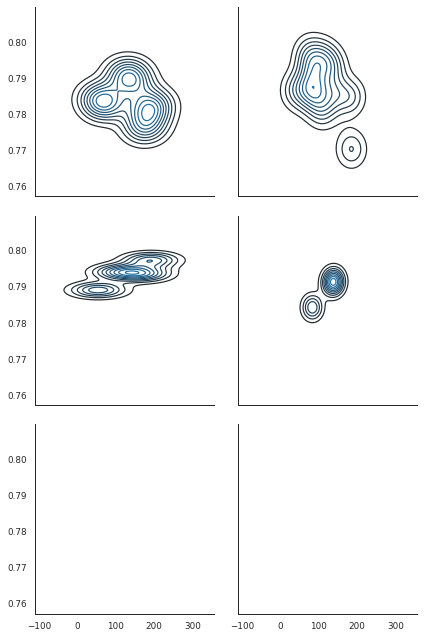

In [163]:
>>> g = sns.FacetGrid(erdf[erdf.unit=='morph'].rename(columns={'learning_rate': 'lr', 'char_seq_feature': 'charsf'}), col="lr", row='charsf')
>>> g = g.map(sns.kdeplot, "epoch", "f")

In [ ]:
>>> g = sns.FacetGrid(erdf[erdf.unit=='token'].rename(columns={'learning_rate': 'lr', 'char_seq_feature': 'charsf'}), col="lr", row='charsf')
>>> g = g.map(sns.kdeplot, "epoch", "f")

In [ ]:
>>> g = sns.FacetGrid(erdf.rename(columns={'char_seq_feature': 'charsf'}), col="batch_size", row='charsf')
>>> g = g.map(plt.scatter, "epoch", "f", edgecolor="w")

In [ ]:
>>> g = sns.FacetGrid(erdf.rename(columns={'char_seq_feature': 'charsf'}), col="batch_size", row='charsf')
>>> g = g.map(sns.kdeplot, "epoch", "f")

In [ ]:
sns.swarmplot(data=erdf, x='arch', y='epoch')

## Batch size

In [2425]:
erdf.groupby(['batch_size', 'arch']).f.median().unstack()

arch        morph_charcnn  morph_charlstm  morph_nochar  token_charcnn  \
batch_size                                                               
1                 0.78170         0.78515        0.7719         0.7476   
8                 0.77795         0.78130        0.7721         0.7478   

arch        token_charlstm  token_nochar  
batch_size                                
1                  0.75575        0.7290  
8                  0.75350        0.7306

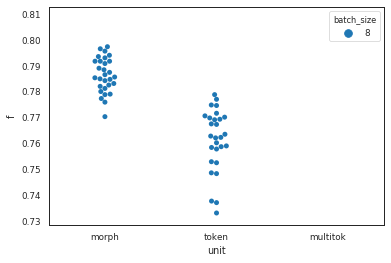

In [164]:
sns.swarmplot(data=erdf, x='unit', y='f', hue='batch_size', split=True)


In [165]:
sns.violinplot(data=erdf, x='unit', y='f', hue='batch_size', split=True, inner='stick')


ValueError: There must be exactly two hue levels to use `split`.'

## Char CNN window size

In [2428]:
erdf.groupby(['unit', 'char_kernel_size']).f.mean().unstack()

char_kernel_size       3.0       5.0       7.0
unit                                          
morph             0.774034  0.777962  0.781965
token             0.745823  0.746515  0.750941

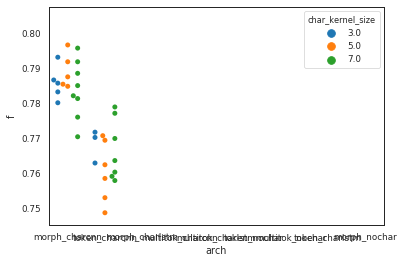

In [166]:
sns.swarmplot(data=erdf, x='arch', y='f', hue='char_kernel_size', split=True)


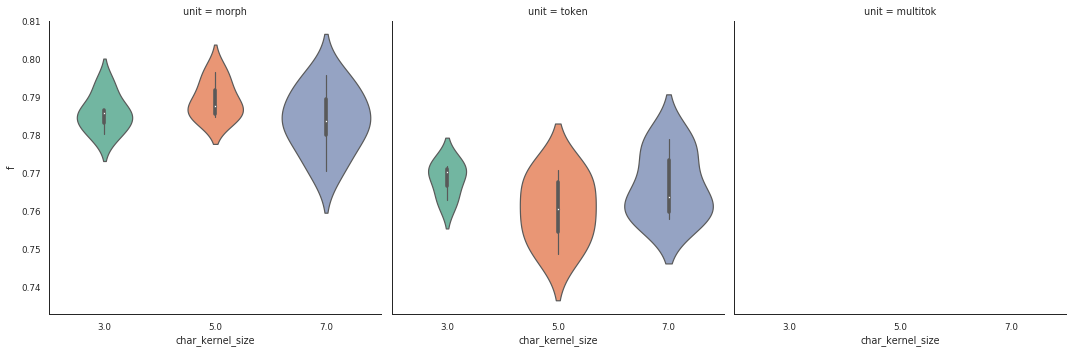

In [167]:
sns.catplot(kind='violin', col='unit', x="char_kernel_size", y="f",
                data=erdf, palette="Set2", 
                scale="count", inner="box")

## LSTM Layers stacked

In [2431]:
erdf.groupby(['lstm_layer', 'arch']).f.median().unstack()

arch        morph_charcnn  morph_charlstm  morph_nochar  token_charcnn  \
lstm_layer                                                               
1                  0.7772          0.7811        0.7751        0.74510   
2                  0.7809          0.7861        0.7719        0.75225   

arch        token_charlstm  token_nochar  
lstm_layer                                
1                   0.7519       0.72890  
2                   0.7594       0.73055

In [2432]:
erdf.groupby(['lstm_layer', 'arch']).f.max().unstack()

arch        morph_charcnn  morph_charlstm  morph_nochar  token_charcnn  \
lstm_layer                                                               
1                  0.7914          0.7966        0.7852         0.7666   
2                  0.7991          0.7974        0.7835         0.7749   

arch        token_charlstm  token_nochar  
lstm_layer                                
1                   0.7618        0.7424  
2                   0.7766        0.7476

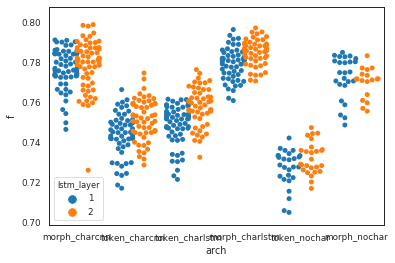

In [2433]:
sns.swarmplot(data=erdf, x='arch', y='f', hue='lstm_layer', split=True)


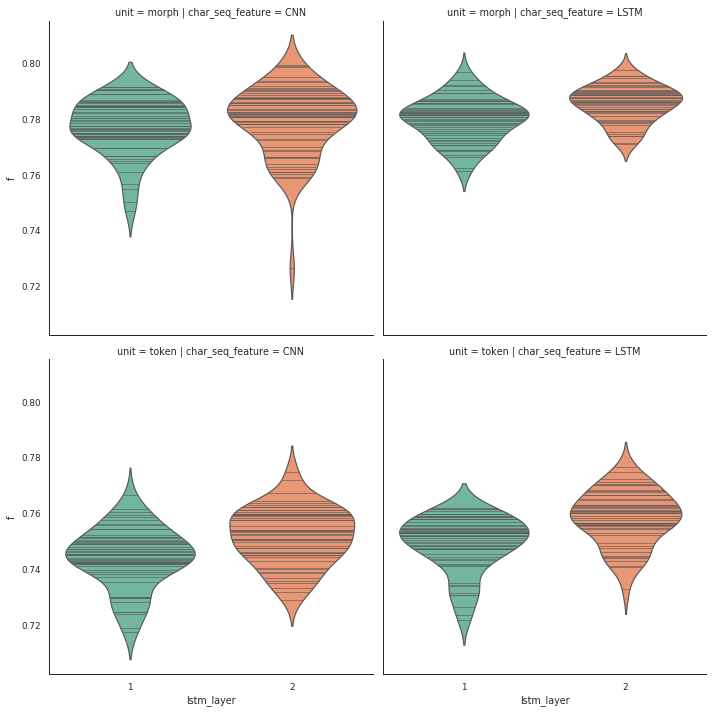

In [2434]:
sns.catplot(kind='violin', row='unit', col='char_seq_feature', 
            x="lstm_layer", y="f",
                data=erdf, palette="Set2", split=True,
                scale="count", inner="stick", scale_hue=True)

## Dropout

In [2435]:
erdf.groupby(['dropout', 'arch']).f.median().unstack()

arch     morph_charcnn  morph_charlstm  morph_nochar  token_charcnn  \
dropout                                                               
0.4             0.7846         0.78210        0.7762         0.7524   
0.5             0.7804         0.78345        0.7760         0.7492   
0.6             0.7722         0.78090        0.7612         0.7422   

arch     token_charlstm  token_nochar  
dropout                                
0.4              0.7521       0.73045  
0.5              0.7578       0.72930  
0.6              0.7552       0.73020

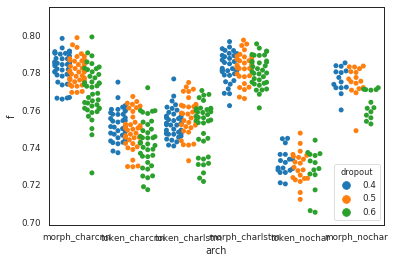

In [2436]:
sns.swarmplot(data=erdf, x='arch', y='f', hue='dropout', split=True)


## Hidden dimensions

### WLSTM

In [2437]:
erdf.groupby(['hidden_dim', 'arch']).f.median().unstack()

arch        morph_charcnn  morph_charlstm  morph_nochar  token_charcnn  \
hidden_dim                                                               
50                 0.7742         0.77540        0.7706         0.7371   
100                0.7850         0.78270        0.7754         0.7512   
200                0.7817         0.78555        0.7774         0.7522   

arch        token_charlstm  token_nochar  
hidden_dim                                
50                 0.74410       0.72360  
100                0.75765       0.73285  
200                0.75715       0.73510

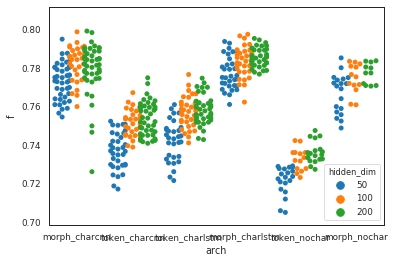

In [2438]:
sns.swarmplot(data=erdf, x='arch', y='f', hue='hidden_dim', split=True)


### CLSTM / CCNN

In [2439]:
erdf.groupby(['char_hidden_dim', 'arch']).f.median().unstack()

arch             morph_charcnn  morph_charlstm  token_charcnn  token_charlstm
char_hidden_dim                                                              
50.0                    0.7819         0.78395         0.7465         0.75485
70.0                    0.7772         0.78200         0.7513         0.75190
90.0                    0.7803         0.78220         0.7467         0.75600

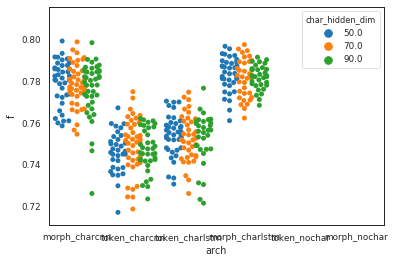

In [2440]:
sns.swarmplot(data=erdf, x='arch', y='f', hue='char_hidden_dim', split=True)

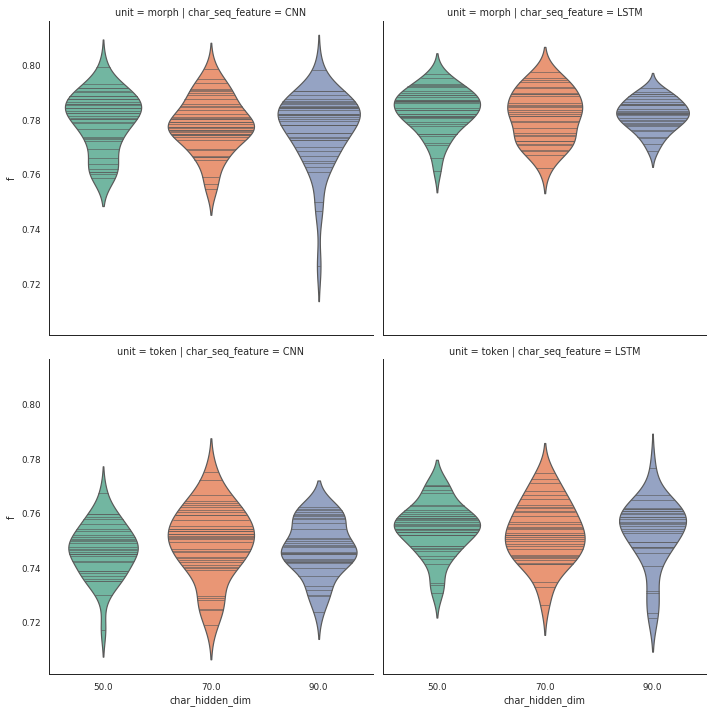

In [2441]:
sns.catplot(kind='violin', row='unit', col='char_seq_feature', 
            x="char_hidden_dim", y="f",
                data=erdf, palette="Set2", split=True,
                scale="count", inner="stick", scale_hue=True)

In [2442]:
erdf.groupby('arch').apply(lambda x: x.sort_values('f', ascending=False).head(2)).T

arch                                  morph_charcnn  \
                                              17957   
acc                                            0.97   
p                                            0.8558   
r                                            0.7495   
f                                            0.7991   
arch                                  morph_charcnn   
unit                                          morph   
conf_num                                        017   
word_seq_feature                               LSTM   
word_emb_dim                                    300   
char_emb_dim                                     30   
iteration                                       100   
bilstm                                         True   
norm_word_emb                                 False   
norm_char_emb                                 False   
ave_batch_loss                                False   
l2                                            1e-08   
lstm_layer                                        2   
batch_size                                        1   
number_normalized                             False   
optimizer                                       SGD   
nbest                                             1   
hidden_dim                                      200   
dropout                                         0.6   
char_seq_feature                                CNN   
use_char                                       True   
use_crf                                        True   
char_hidden_dim                                  50   
char_kernel_size                                  5   
learning_rate                                 0.005   
lr_decay                                       0.05   
momentum                                          0   
epoch                                            57   
model_file_name    morph_charcnn.017.model.57.model   
dset_file_name         morph_charcnn.017.model.dset   

arch                                                 \
                                              41651   
acc                                          0.9689   
p                                            0.8472   
r                                            0.7555   
f                                            0.7987   
arch                                  morph_charcnn   
unit                                          morph   
conf_num                                        053   
word_seq_feature                               LSTM   
word_emb_dim                                    300   
char_emb_dim                                     30   
iteration                                       100   
bilstm                                         True   
norm_word_emb                                 False   
norm_char_emb                                 False   
ave_batch_loss                                False   
l2                                            1e-08   
lstm_layer                                        2   
batch_size                                        8   
number_normalized                             False   
optimizer                                       SGD   
nbest                                             1   
hidden_dim                                      100   
dropout                                         0.5   
char_seq_feature                                CNN   
use_char                                       True   
use_crf                                        True   
char_hidden_dim                                  70   
char_kernel_size                                  7   
learning_rate                                  0.01   
lr_decay                                       0.05   
momentum                                          0   
epoch                                            51   
model_file_name    morph_charcnn.053.model.51.model   
dset_file_name         morph_charcnn.053.model.dset   

arch                                  

In [2443]:
rdf[rdf.groupby('arch').f.transform(max)==rdf.f].sort_values('f', ascending=False).T

17957  \
acc                                            0.97   
p                                            0.8558   
r                                            0.7495   
f                                            0.7991   
arch                                  morph_charcnn   
unit                                          morph   
conf_num                                        017   
word_seq_feature                               LSTM   
word_emb_dim                                    300   
char_emb_dim                                     30   
iteration                                       100   
bilstm                                         True   
norm_word_emb                                 False   
norm_char_emb                                 False   
ave_batch_loss                                False   
l2                                            1e-08   
lstm_layer                                        2   
batch_size                                        1   
number_normalized                             False   
optimizer                                       SGD   
nbest                                             1   
hidden_dim                                      200   
dropout                                         0.6   
char_seq_feature                                CNN   
use_char                                       True   
use_crf                                        True   
char_hidden_dim                                  50   
char_kernel_size                                  5   
learning_rate                                 0.005   
lr_decay                                       0.05   
momentum                                          0   
epoch                                            57   
model_file_name    morph_charcnn.017.model.57.model   
dset_file_name         morph_charcnn.017.model.dset   

                                               13826  \
acc                                           0.9679   
p                                             0.8519   
r                                             0.7495   
f                                             0.7974   
arch                                  morph_charlstm   
unit                                           morph   
conf_num                                         011   
word_seq_feature                                LSTM   
word_emb_dim                                     300   
char_emb_dim                                      30   
iteration                                        100   
bilstm                                          True   
norm_word_emb                                  False   
norm_char_emb                                  False   
ave_batch_loss                                 False   
l2                                             1e-08   
lstm_layer                                         2   
batch_size                                         1   
number_normalized                              False   
optimizer                                        SGD   
nbest                                              1   
hidden_dim                                       100   
dropout                                          0.5   
char_seq_feature                                LSTM   
use_char                                        True   
use_crf                                         True   
char_hidden_dim                                   70   
char_kernel_size                                 NaN   
learning_rate                                  0.015   
lr_decay                                        0.05   
momentum                                           0   
epoch                                             26   
model_file_name    morph_charlstm.011.model.26.model   
dset_file_name         morph_charlstm.011.model.dset   

                                             40290  \
acc                                         0.9666   
p                                           0.8612 